In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["PLOT_LIB_PATH"] = "/cluster/home/mpundir/dev"

import jax

jax.config.update("jax_compilation_cache_dir", os.environ["JAX_CACHE_DIR"])
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import numpy as np

In [2]:
from spectralsolvers.operators import spatial, tensor, fourier_galerkin
from spectralsolvers.fft.transform import _fft, _ifft
from spectralsolvers.solvers.linear import conjugate_gradient_while
from spectralsolvers.solvers.nonlinear import newton_krylov_solver

from functools import partial

from skimage.morphology import disk, rectangle, ellipse
import equinox as eqx
from typing import Callable

import sys  
sys.path.append(os.environ["PLOT_LIB_PATH"])
from plottwist.decorators import plot, subplots, imshow, imshow_grid, STYLE_PATH
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt

In this example, we will test the code for computational homogenization. To this end, we will consider a simple RVE with an inclusion of volume fraction = `0.7 %`. This example is taken from  Gokuzum and Kiep, Wicht et. al (2020) [Computing the effective response of heterogeneous materials with thermomechanically coupled constituents by an implicit fast Fourier transform-based approach](https://onlinelibrary.wiley.com/doi/10.1002/nme.6579).

## constructing an RVE with an inclusion

- inclusion = 1
- solid = 0


We construct the RVE with an volume fraction of 0.7 %

In [4]:
volume_fraction_percentage= 0.007

In [5]:
length = 0.1
H, L = (255, 255)

dx = length/H
dy = length/L

Hmid = int(H / 2)
Lmid = int(L / 2)
vol_inclusion = volume_fraction_percentage*(length*length)
r = int(np.sqrt(vol_inclusion/np.pi)/dx) + 1 # Since the rounding off leads to smaller fraction therefore we add 1. 



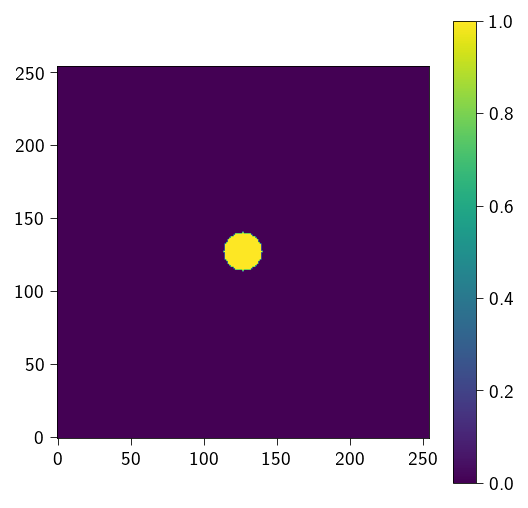

In [7]:
structure = np.zeros((H, L))
structure[Hmid-r: Hmid+1+r, Lmid-r:Lmid+1+r] += disk(r)

plt.style.use(STYLE_PATH)
plt.figure(figsize=(4, 4))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)
plt.show()

In [10]:
ndim = len(structure.shape)
N = structure.shape[0]
shape = [
    N,
] * ndim

grid_size = (N,) * ndim
elasticity_dof_shape = (ndim, ndim) + grid_size

## material parameters

In [12]:
# material parameters + function to convert to grid of scalars
@partial(jax.jit, static_argnames=['inclusion', 'solid'])
def param(X, inclusion, solid):
    return inclusion*jnp.ones_like(X)*(X) + solid*jnp.ones_like(X)*(1-X)

In [13]:
# material parameters
# lames constant
lambda_modulus = {"solid": 2.0, "inclusion": 10}
shear_modulus = {"solid": 1.0, "inclusion": 5}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3

In [14]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

## linear elastic constituive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$
$$\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$


In [24]:
@jax.jit
def strain_energy(eps, _):
    eps_sym = 0.5*(eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym)**2) + jnp.multiply(μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym)))
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

We define `ElasticityOperator` as in the example for linear elasticity.

In [25]:
class ElasticityOperator(eqx.Module):
    Ghat: jnp.ndarray
    funcs: dict[str, Callable]
    elasticity_dof_shape: tuple[int, ...]

    def __init__(
        self,
        N,
        ndim,
        length,
        compute_stress,
        compute_tangent,
        gradient_operator=spatial.Operator.rotated_difference,
    ):
        self.Ghat = fourier_galerkin.compute_projection_operator_legacy(
            grid_size=(N,) * ndim, operator=gradient_operator, length=length
        )
        self.funcs = {}
        self.funcs["fft"] = jax.jit(partial(_fft, N=N, ndim=ndim))
        self.funcs["ifft"] = jax.jit(partial(_ifft, N=N, ndim=ndim))
        self.funcs["compute_tangent"] = compute_tangent
        self.funcs["compute_stress"] = compute_stress
        self.elasticity_dof_shape = (ndim, ndim) + (N,) * ndim



    def __call__(self, deps, args=None):
        deps = deps.reshape(self.elasticity_dof_shape)
        dsigma = self.funcs["compute_tangent"](deps, args)

        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](dsigma)))
        ).reshape(-1)
    
    def residual(self, deps : jnp.ndarray, args=None):
        sigma = self.funcs["compute_stress"](deps, args)
        return jnp.real(
            self.funcs["ifft"](tensor.ddot42(self.Ghat, self.funcs["fft"](sigma)))
        ).reshape(-1)

In [26]:
elasticity_op = ElasticityOperator(
    N,
    ndim,
    length,
    gradient_operator=spatial.Operator.rotated_difference,
    compute_tangent=sigma,
    compute_stress=sigma
)

Now we define a python function that takes the macro strain as an input and return the macro stress. Inside the function, we solve the RVE problem for the given macro strain and return the averaged local stresses as the macro stress.

Later, we use the `jax.jacfwd` to automatically differentiate this function to get the tangent modulus.

In [30]:
@jax.jit
def local_constitutive_update(macro_strain):

    # ----------------------------- NEWTON ITERATIONS -----------------------------
    # initialize stress and strain tensor                         [grid of tensors]
    eps      = jnp.zeros(elasticity_dof_shape)
    # set macroscopic loading
    DE = jnp.zeros(elasticity_dof_shape)
    DE = DE.at[0, 0].set(macro_strain[0])
    DE = DE.at[1, 1].set(macro_strain[1])
    DE = DE.at[0, 1].set(macro_strain[2]/2.)
    DE = DE.at[1, 0].set(macro_strain[2]/2.)

    # initial residual: distribute "DE" over grid using "K4"
    b        = -elasticity_op(DE, None)
    eps      = jax.lax.add(eps, DE) 
    En       = jnp.linalg.norm(eps)

    final_state = newton_krylov_solver(
        state=(DE, b, eps),
        A=elasticity_op,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
        additionals=None,
    )

    DE, b, eps = final_state
    sig = sigma(eps, None)

    # get the macro stress
    macro_sigma = jnp.array([jnp.sum(sig.at[0, 0].get()*dx*dy), 
                             jnp.sum(sig.at[1, 1].get()*dx*dy), 
                             0.5*(jnp.sum(sig.at[1, 0].get()*dx*dy) + jnp.sum(sig.at[0, 1].get()*dx*dy))])
    macro_sigma = macro_sigma/length**2
    
    return macro_sigma, (macro_sigma, sig, eps)

In [31]:
tangent_operator_and_state = jax.jit(jax.jacfwd(
    local_constitutive_update, argnums=0, has_aux=True
))

In [33]:
deps = jnp.array([1.2, 1., 1])
tangent, state = tangent_operator_and_state(deps)

Converged, Residual value : 7.483526639159932e-09


In [34]:
tangent

Array([[ 4.03424410e+00,  2.01513204e+00,  1.38670241e-13],
       [ 2.01513204e+00,  4.03424410e+00, -2.80302303e-13],
       [ 5.45198146e-13, -1.06046683e-13,  1.00930553e+00]],      dtype=float64)

The solution matches the Eshelby's analytical solution. Not exactly, but same result is also obtained by Gokuzum and Kiep. 